In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%pip install git+https://github.com/tee-lab/PyDaddy.git
#import pydaddy
import numpy; #package for numerical (matrix) calculations
import random
import matplotlib.pyplot as plt; #this gives us access to plotting functions
from matplotlib.animation import FuncAnimation # Used to animate the movement of the boids
from matplotlib import rc
import pandas as pd
from IPython.display import HTML, Image # For GIF
rc('animation', html='html5')

In [3]:
def initializeBoids(N, circle_R):                                   # Function to give initial random positional values to the N number of boids
    boid_r_state0 = numpy.zeros(shape=(N))
    boid_pos_angle_state0 = numpy.zeros(shape=(N))
    boid_v_angle_state0 = numpy.zeros( shape=(N))                # We created an angle array of size N and assigned all angles to 0 initially
    boid_pos_state0 = numpy.zeros( shape=(2,N))
    boid_r_state0 = numpy.random.uniform(0,circle_R,N)
    boid_pos_angle_state0 = numpy.random.uniform(-numpy.pi,numpy.pi,N)                   
    boid_v_angle_state0 =  numpy.random.uniform(-numpy.pi,numpy.pi,N)    # Here we assign the direction of velocity to all the boids (from -pi to pi)
    boid_pos_state0[0,:] = boid_r_state0 * numpy.cos(boid_pos_angle_state0)           # Using r and theta, we are calculating position in x and y terms
    boid_pos_state0[1,:] = boid_r_state0 * numpy.sin(boid_pos_angle_state0)
    return  boid_v_angle_state0, boid_pos_state0;

In [4]:
def plotBoids(angle, pos, circle_R, N):                          # Function to plot the boids on a 2D plane (its enclosure)
    fig, axes = plt.subplots()
    axes.set_xlim(-circle_R,circle_R)                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
    axes.set_ylim(-circle_R,circle_R)
    Scale = circle_R/200                                   
    Enclosure = plt.Circle( (0, 0 ),	circle_R , fill= False)
    axes.set_aspect( 1 )
    axes.add_artist( Enclosure )
    plt.title( 'Circle' )
    for n in range(N):
        xpos, ypos = pos[0,n], pos[1,n]
        plt.arrow( xpos, ypos, 5*Scale*numpy.cos(angle[n]), 5*Scale*numpy.sin(angle[n]), head_width=2*Scale, head_length=Scale, fc='green', ec='green') # plotting an arrow to depict the boids, alternative: Use a quiver plot

    plt.show()                                                   # This plots the boids on said enclosure
    return fig

In [5]:
def calcVel(N,v0, angle):
  v_vec = numpy.zeros(shape=(2,N))
  for n in range(N):
    theta= angle[n]
    v_vec[0,n]= v0*numpy.cos(theta)
    v_vec[1,n]= v0*numpy.sin(theta)
  return(v_vec)

In [6]:
def neighborCal(current_angle, current_pos, neighborMeanAngles, N, R, r_r, circle_R):
    for i in range (N):
        neighborAngle=[]
        i_pos = current_pos[:,i].copy()
        n_r = 0
        dir_r_x_list = []     # It is a list containing the x component of the unit vectors of the boids in the zone of repulsion of i
        dir_r_y_list = []     # It is a list containing the y component of the unit vectors of the boids in the zone of repulsion of i
        for j in range (N):
            j_pos = current_pos[:,j].copy()
            dir_ij = [0,0]
            dist_x = i_pos[0] - j_pos[0]
            dist_y = i_pos[1] - j_pos[1]
            dist_ij = numpy.sqrt(numpy.square(dist_x)+numpy.square(dist_y))
            dir_ij[0] = j_pos[0] - i_pos[0]    # This is the x component of the unit vector of the direction vector of i to j
            dir_ij[1] = j_pos[1] - i_pos[1]    # This is the y component of the unit vector of the direction vector of i to j
            if (dist_ij < r_r and i != j):
              n_r = n_r + 1
              dir_r_x_list.append(dir_ij[0])  
              dir_r_y_list.append(dir_ij[1])
            if (n_r == 0):
               if ((r_r <= dist_ij < R) or i==j):
                   neighborAngle.append(current_angle[j]) 
        if (n_r > 0):
          denom_r = 0
          index = 0
          dir_x = 0
          dir_y = 0
          for index in range(len(dir_r_x_list)):
              denom_r = numpy.sqrt(numpy.square(dir_r_x_list[index])+numpy.square(dir_r_y_list[index]))
              dir_x = dir_x + (dir_r_x_list[index]/denom_r)
              dir_y = dir_y + (dir_r_y_list[index]/denom_r)
          neighborMeanAngles[i] =  numpy.arctan2(-dir_y, -dir_x)
        else:
            if (len(neighborAngle) >= 5):
              chosen_angles = random.sample(neighborAngle, 5)
              neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(chosen_angles)), numpy.mean(numpy.cos(chosen_angles)))
            elif (len(neighborAngle) == 4):
              chosen_angles = random.sample(neighborAngle, 4)
              neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(chosen_angles)), numpy.mean(numpy.cos(chosen_angles)))
            elif (len(neighborAngle) == 3):
              chosen_angles = random.sample(neighborAngle,3)
              neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(chosen_angles)), numpy.mean(numpy.cos(chosen_angles)))
            elif (len(neighborAngle) == 2):
              chosen_angles = random.sample(neighborAngle,2)
              neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(chosen_angles)), numpy.mean(numpy.cos(chosen_angles)))
            else:
              neighborMeanAngles[i] =  random.choice(neighborAngle)
    return (neighborMeanAngles)

In [7]:
def reflectPointOnC(x_0, y_0, x_1, y_1, x_2, y_2, circle_R):
    x_3 = x_2 - ((y_2 * (y_1*x_2 - y_2*x_1))/numpy.square(circle_R))
    y_3 = ((x_2*(y_1*x_2 - y_2*x_1))/numpy.square(circle_R)) + y_2
    x_4 = (2*x_3) - x_1
    y_4 = (2*y_3) - y_1
    reflec_angle = numpy.arctan2((y_4 - y_2),(x_4 - x_2))
    return(reflec_angle)

In [8]:
def reflectPointOutC(x_0, y_0, x_1, y_1, circle_R):
    a = numpy.square(x_1-x_0) + numpy.square(y_1-y_0)
    b = 2 * (y_1 - y_0) * ((x_1 - x_0)*y_0 - (y_1 - y_0)*x_0)
    c = numpy.square(x_0*(y_1 - y_0) - y_0*(x_1 - x_0)) - (numpy.square(x_1 - x_0) * numpy.square(circle_R))
    b2_4ac = (numpy.square(b))-(4*a*c)
    rootof_b2_4ac = numpy.sqrt(b2_4ac)
    x_2_a = ((-b) + rootof_b2_4ac)/(2*a)
    y_2_a = numpy.sqrt(numpy.square(circle_R) - numpy.square(x_2_a))
    y_2_a_1 = y_2_a
    y_2_a_2 = -y_2_a
    cos_2a10v = round(((x_1 - x_0)*(x_2_a - x_0) + (y_1 - y_0)*(y_2_a_1 - y_0))/(numpy.sqrt(numpy.square(x_1 - x_0)+numpy.square(y_1 - y_0))*numpy.sqrt(numpy.square(x_2_a - x_0)+numpy.square(y_2_a_1 - y_0))),8)
    diff_theta_2a10_v = numpy.arccos(cos_2a10v)
    cos_2a20v = round(((x_1 - x_0)*(x_2_a - x_0) + (y_1 - y_0)*(y_2_a_2 - y_0))/(numpy.sqrt(numpy.square(x_1 - x_0)+numpy.square(y_1 - y_0))*numpy.sqrt(numpy.square(x_2_a - x_0)+numpy.square(y_2_a_2 - y_0))),8)
    diff_theta_2a20_v = numpy.arccos(cos_2a20v)
    if(diff_theta_2a10_v <= diff_theta_2a20_v):
        y_2_a = y_2_a_1
    else:
        y_2_a = y_2_a_2
    x_2_b = ((-b) - rootof_b2_4ac)/(2*a)
    y_2_b = numpy.sqrt(numpy.square(circle_R) - numpy.square(x_2_b))
    y_2_b_1 = y_2_b
    y_2_b_2 = -y_2_b
    cos_2b10v = round(((x_1 - x_0)*(x_2_b - x_0) + (y_1 - y_0)*(y_2_b_1 - y_0))/(numpy.sqrt(numpy.square(x_1 - x_0)+numpy.square(y_1 - y_0))*numpy.sqrt(numpy.square(x_2_b - x_0)+numpy.square(y_2_b_1 - y_0))),8)
    diff_theta_2b10_v = numpy.arccos(cos_2b10v)
    cos_2b20v = round(((x_1 - x_0)*(x_2_b - x_0) + (y_1 - y_0)*(y_2_b_2 - y_0))/(numpy.sqrt(numpy.square(x_1 - x_0)+numpy.square(y_1 - y_0))*numpy.sqrt(numpy.square(x_2_b - x_0)+numpy.square(y_2_b_2 - y_0))),8)
    diff_theta_2b20_v = numpy.arccos(cos_2b20v)
    if(diff_theta_2b10_v <= diff_theta_2b20_v):
        y_2_b = y_2_b_1
    else:
        y_2_b = y_2_b_2
    if (numpy.sqrt(numpy.square(x_1 - x_2_a)+numpy.square(y_1 - y_2_a)) <= numpy.sqrt(numpy.square(x_1 - x_2_b)+numpy.square(y_1 - y_2_b))):
      x_2 = x_2_a
      y_2 = y_2_a
    else:
      x_2 = x_2_b
      y_2 = y_2_b
    x_3 = x_2 - ((y_2 * (y_1*x_2 - y_2*x_1))/numpy.square(circle_R))
    y_3 = ((x_2*(y_1*x_2 - y_2*x_1))/numpy.square(circle_R)) + y_2
    x_4 = (2*x_3) - x_1
    y_4 = (2*y_3) - y_1
    reflec_angle = numpy.arctan2((y_4 - y_2),(x_4 - x_2))
    return(x_2, y_2, x_4, y_4, reflec_angle)

In [9]:
def state_update(present_angle, present_pos, time_step, eta, R, r_r, circle_R, v0, N, t):      # Function to update the state of boids according to the Viscek model
    current_angle = present_angle.copy()
    current_pos = present_pos.copy()
    next_angle = numpy.zeros(N)                                   # first set the next state to the current state of the boids
    next_pos = numpy.zeros(shape=(2,N)) 
    neighborMeanAngles = numpy.zeros(N)
    neighborMeanAngles = neighborCal(current_angle, current_pos, neighborMeanAngles, N, R, r_r, circle_R)
    #noise = (numpy.random.rand(N) - 0.5) * eta
    noise = numpy.zeros(shape=(N))
    for n in range(N):
      noise[n]=numpy.random.uniform(-eta/2,eta/2)

    next_angle = numpy.add(neighborMeanAngles, noise) # Updating the angular data of the boid by assigning neighbor average angle and adding noise
    
    next_v = numpy.zeros(shape=(2,N))
    v0 = v0
    ta = 0
    for n in range(N):      # Here, we update the boid positions one by one
        v_x = v0*numpy.cos(next_angle[n])
        v_y = v0*numpy.sin(next_angle[n])                               # Current velocity values
        next_pos[ 0,n ] = current_pos[ 0,n ] + time_step*v_x       # x1 = x0 + delta_t * v (updating the position)
        next_pos[ 1,n ] = current_pos[ 1,n ] + time_step*v_y
        next_pos[ 0,n ] = next_pos[0,n]       
        next_pos[ 1,n ] = next_pos[1,n]
        r_x_1_y_1 = numpy.sqrt(numpy.square(next_pos[0,n])+numpy.square(next_pos[1,n])) # Calculating distance of the next position from the centre
        
        if (r_x_1_y_1 == circle_R):                            # Introducing reflective boundary
           x_0 = current_pos[0,n]
           y_0 = current_pos[1,n]
           x_1 = current_pos[ 0,n ] + 1.5*time_step*v_x 
           y_1 = current_pos[ 1,n ] + 1.5*time_step*v_y
           x_2 = next_pos[0,n]
           y_2 = next_pos[1,n]
           next_angle[n] = reflectPointOnC(x_0, y_0, x_1, y_1, x_2, y_2, circle_R)
           
        elif (r_x_1_y_1 > circle_R):                            # Introducing reflective boundary
           x_0 = current_pos[0,n]
           y_0 = current_pos[1,n]
           x_1 = next_pos[0,n]
           y_1 = next_pos[1,n]
           x_2, y_2 = 0, 0
           dist_reflec_point = r_x_1_y_1
           index = 0
           while (dist_reflec_point >= circle_R and index == 0):
               if(dist_reflec_point > circle_R):
                  x_0, y_0, x_1, y_1, next_angle[n] = reflectPointOutC(x_0, y_0, x_1, y_1, circle_R) 
                  dist_reflec_point = numpy.sqrt(numpy.square(x_1)+numpy.square(y_1))
               elif(dist_reflec_point == circle_R):
                  x_2 = x_1
                  y_2 = y_1
                  x_1 = x_1 +  numpy.cos(next_angle[n])
                  y_1 = y_1 + numpy.sin(next_angle[n])
                  next_angle[n] = reflectPointOnC(x_0, y_0, x_1, y_1, x_2, y_2, circle_R)
                  index = 1
           next_pos[0,n] = x_1
           next_pos[1,n] = y_1
            


    next_v[:,:]= calcVel(N,v0, next_angle)
   # for n in range(N):
    #  theta = next_angle[n]
     # v_vector[numpy.array([0,1]) + 2*n] = v0*numpy.array([numpy.cos(theta),numpy.sin(theta)])                                                           # Calculating the next velocity vector of individual n and storing it
    return(next_angle, next_pos, next_v)

In [ ]:
def plottrajectories(trajectory_angles, trajectory_pos, circle_R):        # This plots the trajectory of the boids (i.e., the path followed by each boids during the duration of the simulation)
    fig, axes = plt.subplots()
    axes.set_xlim(-circle_R,circle_R)                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
    axes.set_ylim(-circle_R,circle_R)                                  
    Enclosure = plt.Circle( (0, 0 ),	circle_R , fill= False)
    axes.set_aspect( 1 )
    axes.add_artist( Enclosure )
    plt.title( 'Circle' )
    plt.plot( trajectory_pos[0,:,:].T, trajectory_pos[1,:,:].T ,'.')  # Plottng the trajectories {Plotting the co-ordinates of each boid over time by transposing the matrix to acess the coordinates of each boid over time (without transposing, you would get the coordinates of all boids in one time frame instead)}
    plt.show()

In [ ]:
def plotCall(trajectory_angles, trajectory_pos, Order_param, avg_vel, time, circle_R):
  #Plotting data
    plottrajectories(trajectory_angles, trajectory_pos,circle_R) # trajectory plot
    plt.figure(1)
    plotBoids(trajectory_angles[:,0], trajectory_pos[:,:,0], circle_R, N) # initial state of boids
    plt.figure(2)
    plotBoids(trajectory_angles[:,-1], trajectory_pos[:,:,-1], circle_R, N) #final state of boids 
    plt.figure(3)
    print(avg_vel)                                                # Displaying the order parameter over time
    plt.figure(6)
    fig, axes = plt.subplots()
    axes.set_xlim(0,T)
    axes.set_ylim(0,1)
    plt.scatter(time,avg_vel)                                     # Average velocity plot
    plt.plot(time,avg_vel)
    plt.xlabel("T")
    plt.ylabel("Order parameter (Avg vel)")
    plt.show
    plt.figure(4)                                                   
    plt.ylim(-1,1)
    plt.scatter(time,Order_param[0,:], c = 'red')                # Order parameter (along x and y) plot
    plt.scatter(time,Order_param[1,:], c = 'green')
    plt.plot(time,Order_param[0,:], c = 'red', label = 'M_x')
    plt.plot(time,Order_param[1,:], c = 'green', label = 'M_y')
    plt.legend(['M_x', 'M_y'])
    plt.xlabel("T")
    plt.ylabel("Order parameter (Avg vel)")
    plt.show

In [ ]:
def pyDaddyCall (Order_param,time_step):

    ddsde = pydaddy.Characterize(Order_param, time_step)
    F1 = ddsde.fit('F1', order=3, threshold=0.01)
    print("F1 =",F1)
    F2 = ddsde.fit('F2', order=3, threshold=0.01)
    print("F2 =",F2)
    G11 = ddsde.fit('G11', order=3, threshold=0.01)
    print("G11 =",G11)
    G22 = ddsde.fit('G22', order=3, threshold=0.01)
    print("G22 =",G22)
    G12 = ddsde.fit('G12', order=3, threshold=0.01)
    print("G12 =",G12)
    G21 = ddsde.fit('G21', order=3, threshold=0.01)
    print("G21 =",G21)
    print("When tune = true i.e., when the program sets the treshold:")
    F1 = ddsde.fit('F1', order=3, tune=True)
    print("F1 =",F1)
    F2 = ddsde.fit('F2', order=3, tune=True)
    print("F2 =",F2)
    G11 = ddsde.fit('G11', order=3, tune=True)
    print("G11 =",G11)
    G22 = ddsde.fit('G22', order=3, tune=True)
    print("G22 =",G22)
    G12 = ddsde.fit('G12', order=3, tune=True)
    print("G12 =",G12)
    G21 = ddsde.fit('G21', order=3, tune=True)
    print("G21 =",G21)
    ddsde.drift()
    ddsde.diffusion()
    ddsde.cross_diffusion()
    ddsde.summary()
    ddsde.noise_diagnostics()


In [10]:
def trial(N, eta, T, R, r_r, circle_R, time_step, v0, var): # values listed here are 'defaults': they are used if we don't specify the appropriate constant

    angle_state0, pos_state0 = initializeBoids(N, circle_R)          # We create and initialize state 0 (t=0) positional and angular values of the boids
    trajectory_angles = numpy.zeros(shape=(N,T))                # Creating matrices to store positional and angular data of boids over time
    trajectory_pos = numpy.zeros( shape=(2,N, T));
    trajectory_angles[:,0] = angle_state0
    trajectory_pos[:,:,0] = pos_state0
    v_vector = numpy.zeros(shape=(2,N,T))                       # Matrix to store velocity data of boids over time
    v_vector[:,:,0]= calcVel(N,v0, angle_state0)
    time = numpy.arange(0,T,1) 
    for t in range(T-1):                                        # Looping to update matrices with position, angles and velocity data
        trajectory_angles[:,t+1], trajectory_pos[:,:,t+1], v_vector[:,:,t+1] = state_update( trajectory_angles[:,t], trajectory_pos[:,:,t], time_step, eta, R, r_r, circle_R, v0, N, t) # repeatedly calling state update to get data
    #Order parameter calculation below:
    avg_vel = numpy.zeros(T)    #Initialize an average velocity vector of size T that serves as a order parameter
    M_x = numpy.zeros(T)
    M_y = numpy.zeros(T)
    Order_param = numpy.zeros(shape=(2,T))
    for t in range(T):        # Looping T times to get average velocity for every time step
      avg_vel[t]= numpy.sqrt((numpy.square(numpy.sum(v_vector[0,:,t]))+numpy.square(numpy.sum(v_vector[1,:,t]))))/(N*v0)  # Avg vel = magnitude of (sum of velocity vectors)/ (Number of boids * magnitude of velocity)
      M_x[t] = numpy.sum(v_vector[0,:,t])/(N*v0)
      M_y[t] = numpy.sum(v_vector[1,:,t])/(N*v0)
      Order_param[0,t]=M_x[t]
      Order_param[1,t]=M_y[t]
      
    #print(Order_param)
    #plotCall(trajectory_angles, trajectory_pos, Order_param, avg_vel, time, circle_R)    # Calling function to make the plots
    #numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Viscek_Reflective_Circle_Next_Direction/circle_R_2.256758334191/Trajectory_angles_Simulation_'+str(var)+'.csv', trajectory_angles, delimiter=",")
    #traj_pos_reshaped =trajectory_pos.reshape(trajectory_pos.shape[0], -1)
    #numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Viscek_Reflective_Circle_Next_Direction/circle_R_2.256758334191/Trajectory_positions_Simulation_'+str(var)+'.csv', traj_pos_reshaped, delimiter=",")
    numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Limited_Neighbor_Models/Five_Neighbors_Only_Self_Included/Circle/N_10/Eta_'+str(eta)+'_R_'+str(R)+ 'Order_parameter_Simulation_'+str(var)+'.csv', Order_param, delimiter=",")
    numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Limited_Neighbor_Models/Five_Neighbors_Only_Self_Included/Circle/N_10/Eta_'+str(eta)+'_R_'+str(R)+'Average_velocity_direction_Simulation_'+str(var)+'.csv', avg_vel, delimiter=",")
    #pyDaddyCall (Order_param,time_step)                                                  # Calling funtion to do the data-drive SDE analysis using pyDaddy

    return(trajectory_pos,trajectory_angles)

In [11]:
"""To observe the simulation of the boids moving in accordance to the Viscek model, we use the following function:"""

#Note: The animation doesn't work on colab and has to be executed on spyder or other platforms

def Animate(t):               # Function to get the animation of boids moving over time
      if (t<anim_time):              # Function will run till we reach timestep T
                         
        plt.cla()             # Clears the plot before displaying new positions of the boids
        plt.xlim(-(circle_R+1),(circle_R+1))                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
        plt.ylim(-(circle_R+1),(circle_R+1))
        plt.gca().set_aspect(1)                                    
        Enclosure = plt.Circle( (0, 0 ),	circle_R , fill= False)
        plt.gca().add_patch(Enclosure)
        plt.title("T = %s" % (t/10))
        plt.suptitle("N=%i  " %N + "eta=%f  " %eta + "Circle_R=%f  " %circle_R + "r=%f  " %R + "r_r=%s " %r_r + "v=%f  " %v)
        Scale = circle_R/200 
        plt.quiver(traj_pos[0,:,t],traj_pos[1,:,t], numpy.cos(traj_angles[:, t]), numpy.sin(traj_angles[:, t]),  pivot='tip', scale = 30, color = "red") # Displaying the boids positions at time t

<ipython-input-8-dae0bc93ec04>:11: RuntimeWarning: invalid value encountered in double_scalars
  cos_2a10v = round(((x_1 - x_0)*(x_2_a - x_0) + (y_1 - y_0)*(y_2_a_1 - y_0))/(numpy.sqrt(numpy.square(x_1 - x_0)+numpy.square(y_1 - y_0))*numpy.sqrt(numpy.square(x_2_a - x_0)+numpy.square(y_2_a_1 - y_0))),8)
<ipython-input-8-dae0bc93ec04>:23: RuntimeWarning: invalid value encountered in double_scalars
  cos_2b10v = round(((x_1 - x_0)*(x_2_b - x_0) + (y_1 - y_0)*(y_2_b_1 - y_0))/(numpy.sqrt(numpy.square(x_1 - x_0)+numpy.square(y_1 - y_0))*numpy.sqrt(numpy.square(x_2_b - x_0)+numpy.square(y_2_b_1 - y_0))),8)


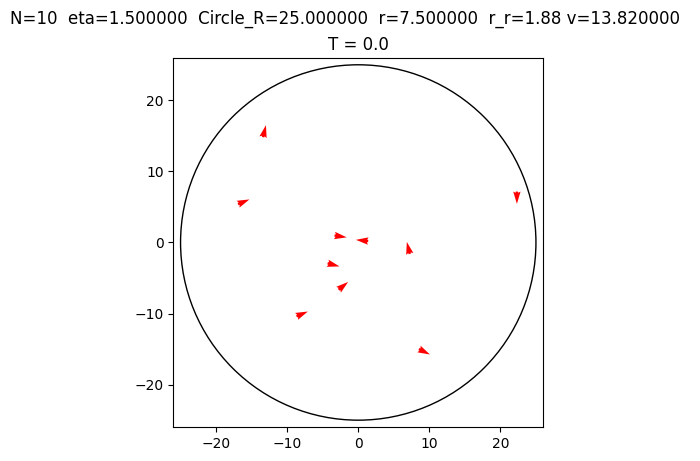

In [12]:
# The next few lines of code is to collect parameter values (input) from the user
#Note: The spyder platform I use doesn't support collecting imput from users so if you face the same problem, just directly assign values to N and eta in the code.
#N = int(input("Enter the number of boids you want in the enclosure: "))
#eta = float(input("Enter the maximum noise in the system: "))
#circle_R = float(input("Enter the radius of the circular enclosure (circle_R): "))
#R = float(input("Enter the radius of interaction (in units):"))
#v = float(input("Enter the speed of the boids (in units/sec):"))
N = 10
eta = 1.5
circle_R = 25
r_r = 1.88
R = 7.5 
v = 13.82
T = 1000000   # This is the number of timesteps in the simulation
time_step = 0.1
anim_time = 1000
var = 0
set_of_R = [7.5]
eta_values = [1.5]
for eta in eta_values:
  for R in set_of_R:
    for var in range(1):
      traj_pos, traj_angles = trial(N, eta, T, R, r_r, circle_R, time_step, v, var)# Calling the trial function
      t=0 
      plt.figure(5)
      ani = FuncAnimation(plt.gcf(),Animate,interval=1, frames=anim_time, repeat_delay=1000)    # Animation
      ani.save('/content/drive/MyDrive/Colab_Notebooks_New/Limited_Neighbor_Models/Five_Neighbors_Only_Self_Included/Circle/N_10/Eta_'+str(eta)+'_R_'+str(R)+'Simulation_'+str(var)+'.gif', writer = "pillow", fps=40)


In [ ]:
"""The following snippet of code is to call the animation function! This should result in a animation of boids moving."""

t=0 
plt.figure(5)
ani = FuncAnimation(plt.gcf(),Animate,interval=1, frames=T, repeat_delay=1000)    # Animation
ani.save('Circle_Enclosure_N_20_eta_1.5_CR_5_r_1_random_start.gif', fps=45)
plt.show() 

In [ ]:
x=[1,2,3,4]
for i in x:
  print (i)

1
2
3
4
